In [2]:
import sys
sys.path.insert(0, '/users/junzheyin/iris/src')
print(sys.path)

['/users/junzheyin/iris/src', '/users/junzheyin/iris/src/models/tokenizer', '/users/junzheyin/anaconda3/envs/iris/lib/python38.zip', '/users/junzheyin/anaconda3/envs/iris/lib/python3.8', '/users/junzheyin/anaconda3/envs/iris/lib/python3.8/lib-dynload', '', '/users/junzheyin/.local/lib/python3.8/site-packages', '/users/junzheyin/anaconda3/envs/iris/lib/python3.8/site-packages']


In [3]:
from dataclasses import dataclass
from typing import Any, Tuple

from einops import rearrange
import torch
import torch.nn as nn

#from dataset import Batch
from lpips import LPIPS
from nets import Encoder, Decoder
from utils import LossWithIntermediateLosses

batch=1
@dataclass
class TokenizerEncoderOutput:
    z: torch.FloatTensor
    z_quantized: torch.FloatTensor
    tokens: torch.LongTensor


class Tokenizer(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int, encoder: Encoder, decoder: Decoder, with_lpips: bool) -> None:
        super().__init__()
        self.vocab_size = vocab_size
        self.encoder = encoder
        self.pre_quant_conv = torch.nn.Conv2d(encoder.config.z_channels, embed_dim, 1)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.post_quant_conv = torch.nn.Conv2d(embed_dim, decoder.config.z_channels, 1)
        self.decoder = decoder
        self.embedding.weight.data.uniform_(-1.0 / vocab_size, 1.0 / vocab_size)
        self.lpips = LPIPS().eval() if with_lpips else None

    def __repr__(self) -> str:
        return "tokenizer"

    def forward(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> Tuple[torch.Tensor]:
        outputs = self.encode(x, should_preprocess)
        decoder_input = outputs.z + (outputs.z_quantized - outputs.z).detach()
        reconstructions = self.decode(decoder_input, should_postprocess)
        return outputs.z, outputs.z_quantized, reconstructions

    def compute_loss(self, x, **kwargs: Any) -> LossWithIntermediateLosses:
        assert self.lpips is not None
        observations = x
        z, z_quantized, reconstructions = self(observations, should_preprocess=False, should_postprocess=False)

        # Codebook loss. Notes:
        # - beta position is different from taming and identical to original VQVAE paper
        # - VQVAE uses 0.25 by default
        beta = 1.0
        commitment_loss = (z.detach() - z_quantized).pow(2).mean() + beta * (z - z_quantized.detach()).pow(2).mean()

        reconstruction_loss = torch.abs(observations - reconstructions).mean()
        perceptual_loss = torch.mean(self.lpips(observations, reconstructions))

        return LossWithIntermediateLosses(commitment_loss=commitment_loss, reconstruction_loss=reconstruction_loss,perceptual_loss=perceptual_loss)

    def encode(self, x: torch.Tensor, should_preprocess: bool = False) -> TokenizerEncoderOutput:
        if should_preprocess:
            x = self.preprocess_input(x)
        #print("Shape of x:", x.shape)
        shape = x.shape  # (..., C, H, W)
        x = x.view(-1, *shape[-3:])
        #print("Shape of x as (x_view):", x.shape)
        z = self.encoder(x)
        #print("Shape of z:",z.shape)
        z = self.pre_quant_conv(z)
        b, e, h, w = z.shape
        z_flattened = rearrange(z, 'b e h w -> (b h w) e')
        #print("Shape of z_flattend:",z_flattened.shape)
        dist_to_embeddings = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1) - 2 * torch.matmul(z_flattened, self.embedding.weight.t())

        tokens = dist_to_embeddings.argmin(dim=-1)
        #print("Shape of tokens:",tokens.shape)
        z_q = rearrange(self.embedding(tokens), '(b h w) e -> b e h w', b=b, e=e, h=h, w=w).contiguous()
        #print("Shape of z_q:",z_q.shape)
        # Reshape to original
        z = z.reshape(*shape[:-3], *z.shape[1:])
        #print("Shape of reshaped z:", z.shape)
        z_q = z_q.reshape(*shape[:-3], *z_q.shape[1:])
        #print("Shape of reshaped z_q:", z_q.shape)
        tokens = tokens.reshape(*shape[:-3], -1)
        #print("Shape of tokens:", tokens.shape)

        return TokenizerEncoderOutput(z, z_q, tokens)

    def decode(self, z_q: torch.Tensor, should_postprocess: bool = False) -> torch.Tensor:
        shape = z_q.shape  # (..., E, h, w)
        z_q = z_q.view(-1, *shape[-3:])
        z_q = self.post_quant_conv(z_q)
        rec = self.decoder(z_q)
        rec = rec.reshape(*shape[:-3], *rec.shape[1:])
        if should_postprocess:
            rec = self.postprocess_output(rec)
        return rec

    @torch.no_grad()
    def encode_decode(self, x: torch.Tensor, should_preprocess: bool = False, should_postprocess: bool = False) -> torch.Tensor:
        z_q = self.encode(x, should_preprocess).z_quantized
        return self.decode(z_q, should_postprocess)

    def preprocess_input(self, x: torch.Tensor) -> torch.Tensor:
        """x is supposed to be channels first and in [0, 1]"""
        return x.mul(2).sub(1)

    def postprocess_output(self, y: torch.Tensor) -> torch.Tensor:
        """y is supposed to be channels first and in [-1, 1]"""
        return y.add(1).div(2)


In [4]:
from typing import List

import torch
import torch.nn as nn
## Configuration file for the Endocer and Decoder
@dataclass
class EncoderDecoderConfig:
    resolution: int
    in_channels: int
    z_channels: int
    ch: int
    ch_mult: List[int]
    num_res_blocks: int
    attn_resolutions: List[int]
    out_ch: int
    dropout: float

In [5]:
encoder = Encoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=1024,
                                        ch=128,
                                        ch_mult= [1, 1, 1, 2, 2, 4],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],
                                        out_ch= 1,
                                        dropout= 0.0))
decoder=Decoder(EncoderDecoderConfig(resolution=256,
                                       in_channels=1,
                                        z_channels=1024,
                                        ch=128,
                                        ch_mult=[1, 1, 1, 2, 2, 4 ],
                                        num_res_blocks= 2,
                                        attn_resolutions= [8],
                                        out_ch= 1,
                                        dropout= 0.0))
vocab_size = 1024 # actual vocabulary size 
embed_dim = 1024  # the desired embedding dimension of the codebook (coebook dim)
tokenizer = Tokenizer(vocab_size, embed_dim, encoder, decoder, with_lpips=True)
print(encoder)
print(decoder)

Tokenizer : shape of latent is (1024, 8, 8).
Encoder(
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): Module(
      (block): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (attn): ModuleLis

In [6]:
learning_rate=0.0001 # cfg training file 
optimizer_tokenizer = torch.optim.Adam(tokenizer.parameters(), lr=learning_rate)

In [7]:
# Define dataset
import torch
import sys
#from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))
#print(image.shape)

In [8]:
# develop dataset
from torch.cuda.amp import autocast
#from torch.autograd import Variable
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 

df_train = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('/users/hbi/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/hbi/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/hbi/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('/users/hbi/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('/users/hbi/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

print(len(dataset_train), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size=1, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size=1, shuffle=False, num_workers=8),
          
          'train_aa5' :DataLoader(dataset_train_aa, batch_size=1, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size=1, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size=1, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size=1, shuffle=False, num_workers=8),
          }

32183 3493 3560


In [9]:
# Initializing Device as cuda:0
cuda_version = torch.version.cuda
print("CUDA version:", cuda_version)
print(torch.cuda.is_available())
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print("PyTorch version:", torch.__version__)

CUDA version: 11.3
True
cuda:1
PyTorch version: 1.11.0


In [9]:
##Training loop VQVAE 
import numpy as np
from collections import defaultdict
loss_total_step=0.0
intermediate_losses = defaultdict(float)
num_epochs=80
device = torch.device("cuda:0")  # Specify the GPU device
epoch_start=0
tokenizer.to(device)
all_metrics = []  # List to store metrics for all epochs

for epoch in range(epoch_start,num_epochs):
    save_epoch = epoch in [0,2,4,9,19,29,39,49,59,79]
    #save_epoch = epoch in [2]
    loss_total_epoch=0.0
    optimizer_tokenizer.zero_grad()
    intermediate_losses = {}
    print("epoch {}".format(epoch))
    for i, images in enumerate(loaders['train']):
        loss_total_step=0.0
        image = images[0]
        image = image.unsqueeze(1)
        image = image[3:4, :, :, :]
        input_image= image.to(device)  # batch x
        #print(input_image.size())
        encoder_output = tokenizer.encode(input_image)
        losses=tokenizer.compute_loss(input_image)
        
        loss_total_step += losses.loss_total 
        loss_total_epoch += loss_total_step.item()/64
        if (i+1) % 64 == 0:
            (loss_total_step/64).backward()
            optimizer_tokenizer.step()
            optimizer_tokenizer.zero_grad()
            
            print("Losses: Total = {:.4f}".format(loss_total_step.item()))
            #loss_total_step=0.0
        

        for loss_name, loss_value in losses.intermediate_losses.items():
                intermediate_losses[f"{str(tokenizer)}/train/{loss_name}"] = loss_value/64
    
        
    metrics = {f'{str(Tokenizer)}/train/total_loss': loss_total_epoch, **intermediate_losses}
    print("Epoch {}: Total Loss = {:.4f}".format(epoch, metrics[f'{str(Tokenizer)}/train/total_loss']))

    if save_epoch:
        torch.save({
        'model_state_dict': tokenizer.state_dict(),
        'optimizer_state_dict': optimizer_tokenizer.state_dict(),
        }, '/space/junzheyin/check1/vqvae_checkpoint_epoch{}'.format(epoch+1))

    all_metrics.append(metrics)  # Save metrics for the current epoch to the list


# Convert the metrics list to a NumPy array
metrics_array = np.array(all_metrics)

# Save the metrics array as a NumPy file
np.save('/space/junzheyin/metrics/', metrics_array)
# Print all errors from each epoch's metrics dictionary
# print(all_metrics)

KeyboardInterrupt: 

In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cuda:1")
#print(device)
optimizer_checkpoint = torch.load('/space/ankushroy/Tokeniser_exp2_1024_embdim_4/vqvae_epoch1', map_location=device)

# Print the keys in the optimizer_checkpoint dictionary
print(optimizer_checkpoint.keys())

# Adjust the key name based on the actual key in the optimizer_checkpoint dictionary
optimizer_state_dict = optimizer_checkpoint['state']
optimizer_tokenizer.load_state_dict(optimizer_checkpoint)

# Check if the keys match
loaded_keys = set(optimizer_checkpoint.keys())
optimizer_keys = set(optimizer_tokenizer.state_dict().keys())

if loaded_keys == optimizer_keys:
    print("Keys match!")
else:
    print("Keys do not match.")


MSE: 14.078 MAE: 0.826 PCC: 0.476 
 CSI(1mm): 0.372 CSI(2mm): 0.288 CSI(8mm): 0.167 
 ACC(1mm): 0.914 ACC(2mm): 0.932 ACC(8mm): 0.973 
 FSS(1km): 0.913 FSS(10km): 0.886 FSS(20km): 0.824 FSS(30km): 0.65


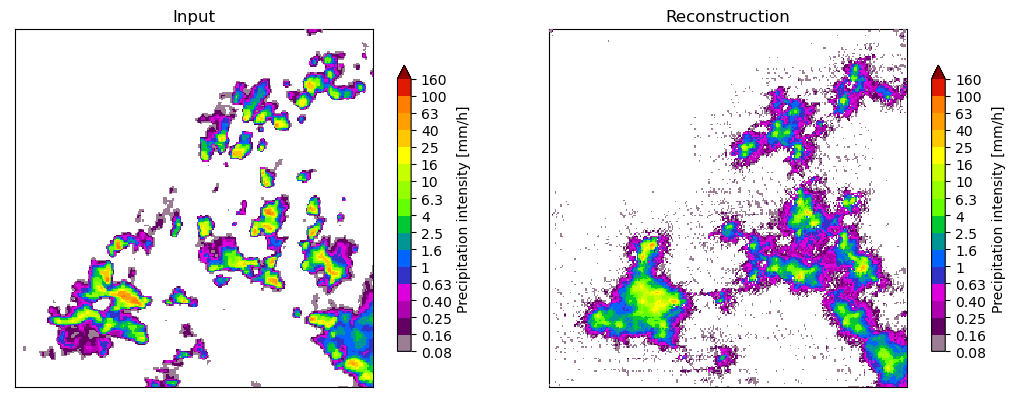

MSE: 14.084 MAE: 0.88 PCC: 0.438 
 CSI(1mm): 0.393 CSI(2mm): 0.31 CSI(8mm): 0.165 
 ACC(1mm): 0.904 ACC(2mm): 0.927 ACC(8mm): 0.971 
 FSS(1km): 0.892 FSS(10km): 0.875 FSS(20km): 0.828 FSS(30km): 0.644


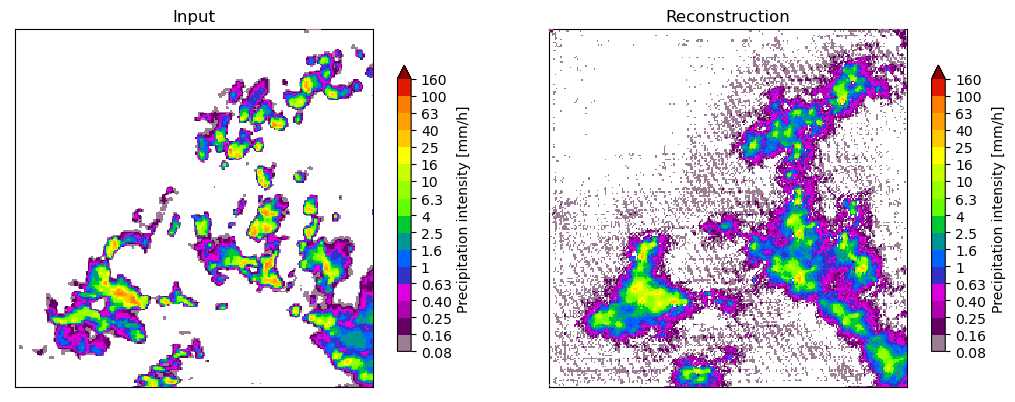

MSE: 2.86 MAE: 0.441 PCC: 0.634 
 CSI(1mm): 0.485 CSI(2mm): 0.46 CSI(8mm): 0.088 
 ACC(1mm): 0.902 ACC(2mm): 0.943 ACC(8mm): 0.988 
 FSS(1km): 0.944 FSS(10km): 0.929 FSS(20km): 0.897 FSS(30km): 0.806


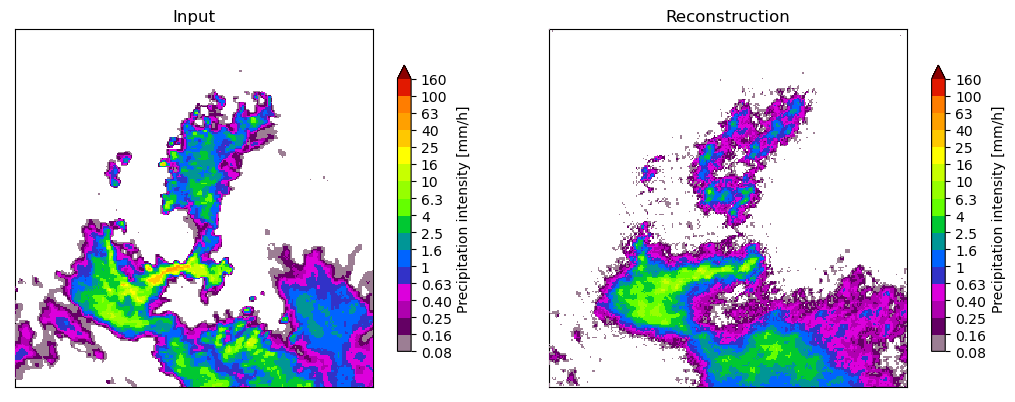

MSE: 14.599 MAE: 0.853 PCC: 0.385 
 CSI(1mm): 0.38 CSI(2mm): 0.312 CSI(8mm): 0.137 
 ACC(1mm): 0.916 ACC(2mm): 0.936 ACC(8mm): 0.97 
 FSS(1km): 0.876 FSS(10km): 0.852 FSS(20km): 0.792 FSS(30km): 0.62


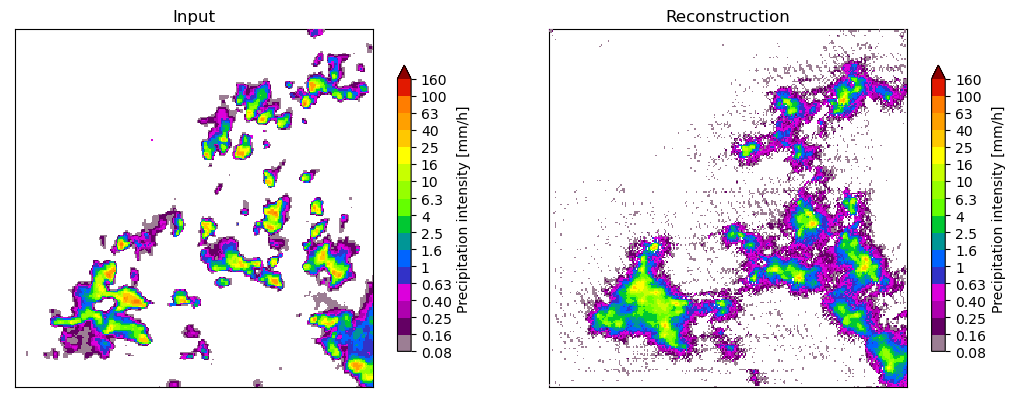

MSE: 13.963 MAE: 0.783 PCC: 0.344 
 CSI(1mm): 0.356 CSI(2mm): 0.288 CSI(8mm): 0.088 
 ACC(1mm): 0.92 ACC(2mm): 0.939 ACC(8mm): 0.973 
 FSS(1km): 0.885 FSS(10km): 0.862 FSS(20km): 0.801 FSS(30km): 0.605


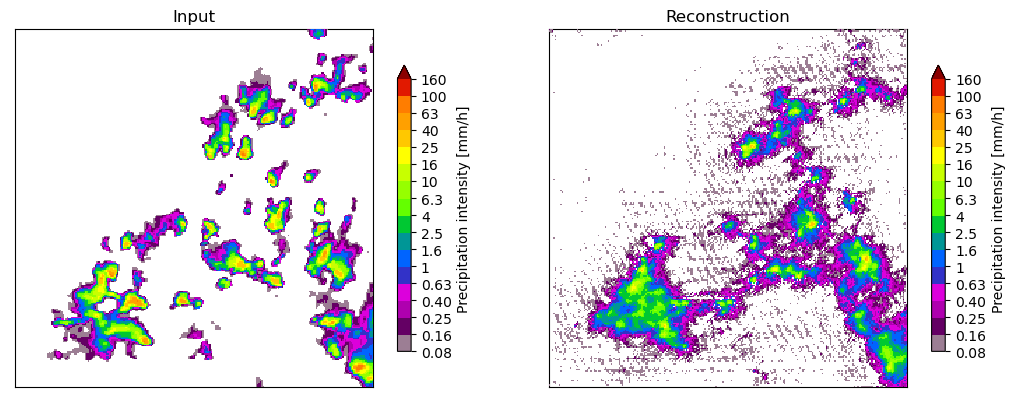

pcc_average: 0.4554


In [15]:
#torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
device = 'cuda:0'
pcc_average = 0
tokenizer=tokenizer.to(device)
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break

    
    checkpoint = torch.load('/space/junzheyin/check4/vqvae_checkpoint_epoch250', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    
    image = images[0]
    image = image.unsqueeze(1)
    image = image[3:4, :, :, :]
    input_image= image.to(device)  # batch x
        #print(input_image.size())
    a_r = tokenizer.encode_decode(input_image)
        #checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/vqvae_epoch70', map_location = 'cpu')
        #vae.load_state_dict(checkpoint)
        #a_r2 = vae(a)

    for t in range(1):
        a_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
        a_r_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
        
        scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
        scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
        scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
        scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
        
        scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average += float(np.around(scores_cont['corr_p'],3))
        if True:
            print('MSE:', np.around(scores_cont['MSE'],3), 
                    'MAE:', np.around(scores_cont['MAE'],3), 
                    'PCC:', np.around(scores_cont['corr_p'],3),'\n', 
                    'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                    'FSS(1km):', np.around(scores_spatial[0][0],3),
                    'FSS(10km):', np.around(scores_spatial[1][0],3),
                    'FSS(20km):', np.around(scores_spatial[2][0],3),
                    'FSS(30km):', np.around(scores_spatial[3][0],3)
                    )  
            plt.figure(figsize=(16, 4))
            plt.subplot(131)
            plot_precip_field(a_r_display, title="Input")
            plt.subplot(132)
            plot_precip_field(a_display, title="Reconstruction")
            
            plt.tight_layout()
            plt.show()
print('pcc_average:', pcc_average/i)

MSE: 12.845 MAE: 0.884 PCC: 0.461 
 MSE: 13.187 MAE: 0.853 PCC: 0.436 
 MSE: 12.446 MAE: 0.795 PCC: 0.496 
 MSE: 11.962 MAE: 0.822 PCC: 0.507 
 CSI(1mm): 0.444 CSI(2mm): 0.394 CSI(8mm): 0.214 
 CSI(1mm): 0.395 CSI(2mm): 0.315 CSI(8mm): 0.132 
 CSI(1mm): 0.441 CSI(2mm): 0.388 CSI(8mm): 0.129 
 CSI(1mm): 0.445 CSI(2mm): 0.39 CSI(8mm): 0.172 
 ACC(1mm): 0.908 ACC(2mm): 0.935 ACC(8mm): 0.969 
 ACC(1mm): 0.915 ACC(2mm): 0.936 ACC(8mm): 0.97 
 ACC(1mm): 0.916 ACC(2mm): 0.941 ACC(8mm): 0.971 
 ACC(1mm): 0.913 ACC(2mm): 0.938 ACC(8mm): 0.97 
 FSS(1km): 0.904 FSS(10km): 0.884 FSS(20km): 0.835 FSS(30km): 0.68 
 FSS(1km): 0.914 FSS(10km): 0.894 FSS(20km): 0.844 FSS(30km): 0.682 
 FSS(1km): 0.934 FSS(10km): 0.908 FSS(20km): 0.854 FSS(30km): 0.703 
 FSS(1km): 0.93 FSS(10km): 0.904 FSS(20km): 0.85 FSS(30km): 0.696 



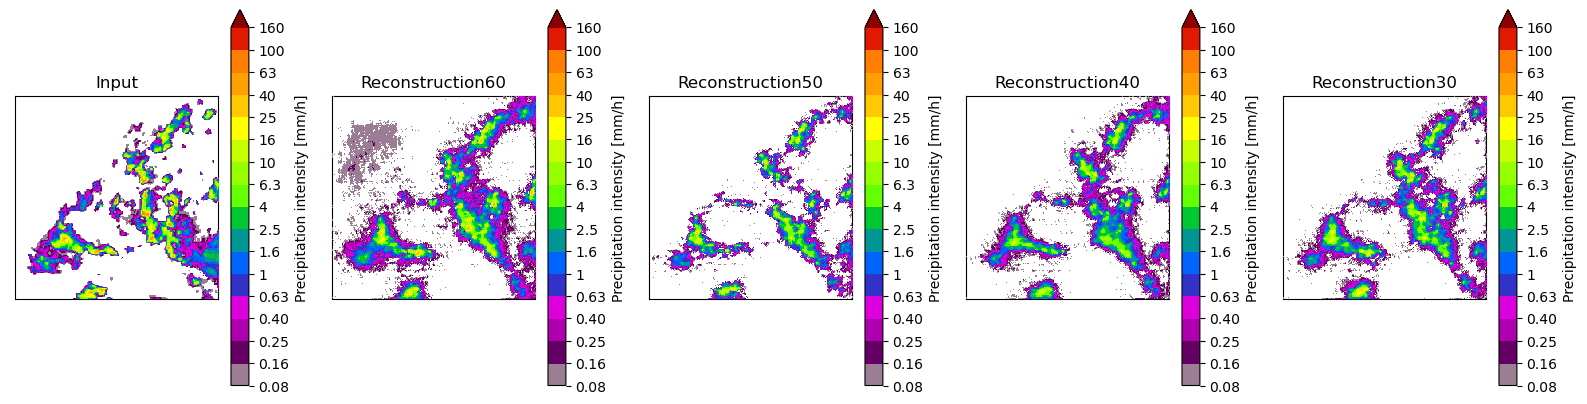

MSE: 14.391 MAE: 0.886 PCC: 0.396 
 MSE: 13.293 MAE: 0.846 PCC: 0.466 
 MSE: 13.404 MAE: 0.819 PCC: 0.464 
 MSE: 13.745 MAE: 0.849 PCC: 0.436 
 CSI(1mm): 0.433 CSI(2mm): 0.366 CSI(8mm): 0.161 
 CSI(1mm): 0.417 CSI(2mm): 0.347 CSI(8mm): 0.18 
 CSI(1mm): 0.437 CSI(2mm): 0.387 CSI(8mm): 0.141 
 CSI(1mm): 0.419 CSI(2mm): 0.366 CSI(8mm): 0.154 
 ACC(1mm): 0.908 ACC(2mm): 0.932 ACC(8mm): 0.967 
 ACC(1mm): 0.909 ACC(2mm): 0.931 ACC(8mm): 0.969 
 ACC(1mm): 0.911 ACC(2mm): 0.935 ACC(8mm): 0.969 
 ACC(1mm): 0.911 ACC(2mm): 0.935 ACC(8mm): 0.968 
 FSS(1km): 0.784 FSS(10km): 0.771 FSS(20km): 0.736 FSS(30km): 0.612 
 FSS(1km): 0.939 FSS(10km): 0.915 FSS(20km): 0.86 FSS(30km): 0.701 
 FSS(1km): 0.929 FSS(10km): 0.903 FSS(20km): 0.848 FSS(30km): 0.7 
 FSS(1km): 0.926 FSS(10km): 0.9 FSS(20km): 0.843 FSS(30km): 0.695 



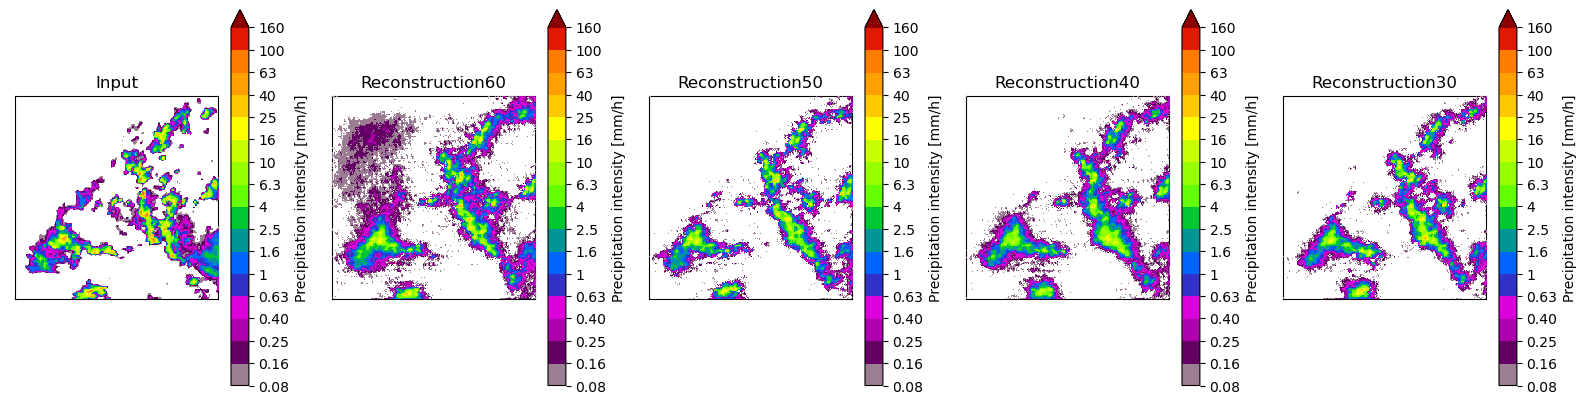

MSE: 1.659 MAE: 0.423 PCC: 0.605 
 MSE: 1.62 MAE: 0.446 PCC: 0.619 
 MSE: 1.726 MAE: 0.447 PCC: 0.593 
 MSE: 1.587 MAE: 0.425 PCC: 0.626 
 CSI(1mm): 0.479 CSI(2mm): 0.288 CSI(8mm): 0.027 
 CSI(1mm): 0.502 CSI(2mm): 0.319 CSI(8mm): 0.043 
 CSI(1mm): 0.428 CSI(2mm): 0.209 CSI(8mm): 0.058 
 CSI(1mm): 0.477 CSI(2mm): 0.325 CSI(8mm): 0.055 
 ACC(1mm): 0.905 ACC(2mm): 0.926 ACC(8mm): 0.993 
 ACC(1mm): 0.909 ACC(2mm): 0.927 ACC(8mm): 0.993 
 ACC(1mm): 0.898 ACC(2mm): 0.917 ACC(8mm): 0.993 
 ACC(1mm): 0.907 ACC(2mm): 0.928 ACC(8mm): 0.993 
 FSS(1km): 0.947 FSS(10km): 0.932 FSS(20km): 0.904 FSS(30km): 0.813 
 FSS(1km): 0.895 FSS(10km): 0.877 FSS(20km): 0.843 FSS(30km): 0.736 
 FSS(1km): 0.938 FSS(10km): 0.923 FSS(20km): 0.892 FSS(30km): 0.782 
 FSS(1km): 0.929 FSS(10km): 0.913 FSS(20km): 0.882 FSS(30km): 0.781 



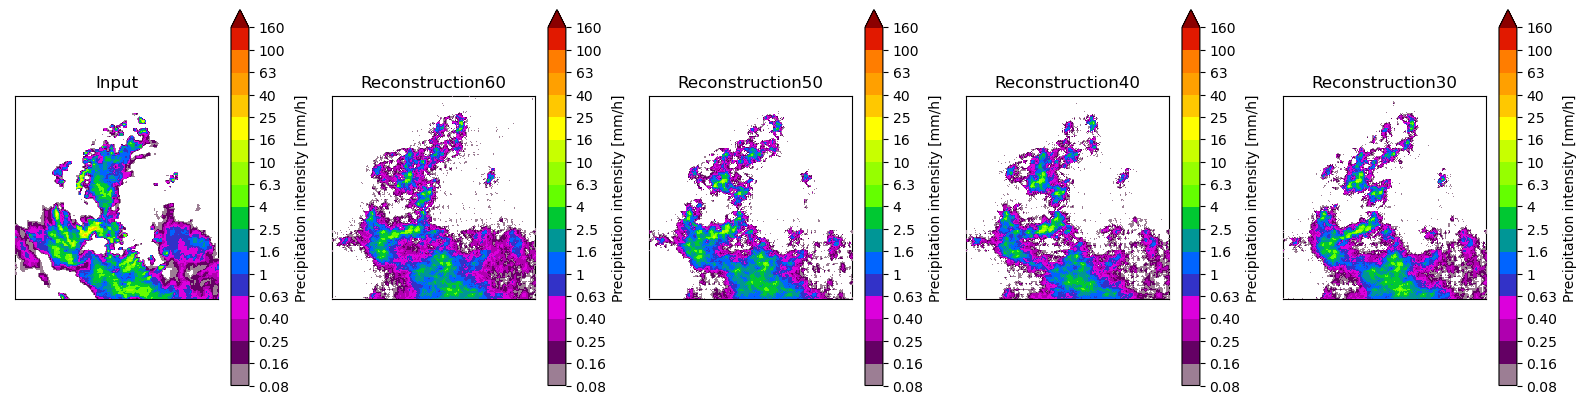

MSE: 15.15 MAE: 0.901 PCC: 0.465 
 MSE: 15.865 MAE: 0.884 PCC: 0.469 
 MSE: 14.864 MAE: 0.838 PCC: 0.499 
 MSE: 14.811 MAE: 0.903 PCC: 0.483 
 CSI(1mm): 0.433 CSI(2mm): 0.348 CSI(8mm): 0.194 
 CSI(1mm): 0.379 CSI(2mm): 0.291 CSI(8mm): 0.108 
 CSI(1mm): 0.426 CSI(2mm): 0.379 CSI(8mm): 0.174 
 CSI(1mm): 0.411 CSI(2mm): 0.357 CSI(8mm): 0.184 
 ACC(1mm): 0.906 ACC(2mm): 0.931 ACC(8mm): 0.97 
 ACC(1mm): 0.912 ACC(2mm): 0.933 ACC(8mm): 0.97 
 ACC(1mm): 0.909 ACC(2mm): 0.937 ACC(8mm): 0.971 
 ACC(1mm): 0.904 ACC(2mm): 0.931 ACC(8mm): 0.969 
 FSS(1km): 0.887 FSS(10km): 0.869 FSS(20km): 0.824 FSS(30km): 0.668 
 FSS(1km): 0.929 FSS(10km): 0.909 FSS(20km): 0.857 FSS(30km): 0.692 
 FSS(1km): 0.942 FSS(10km): 0.921 FSS(20km): 0.874 FSS(30km): 0.73 
 FSS(1km): 0.932 FSS(10km): 0.908 FSS(20km): 0.855 FSS(30km): 0.704 



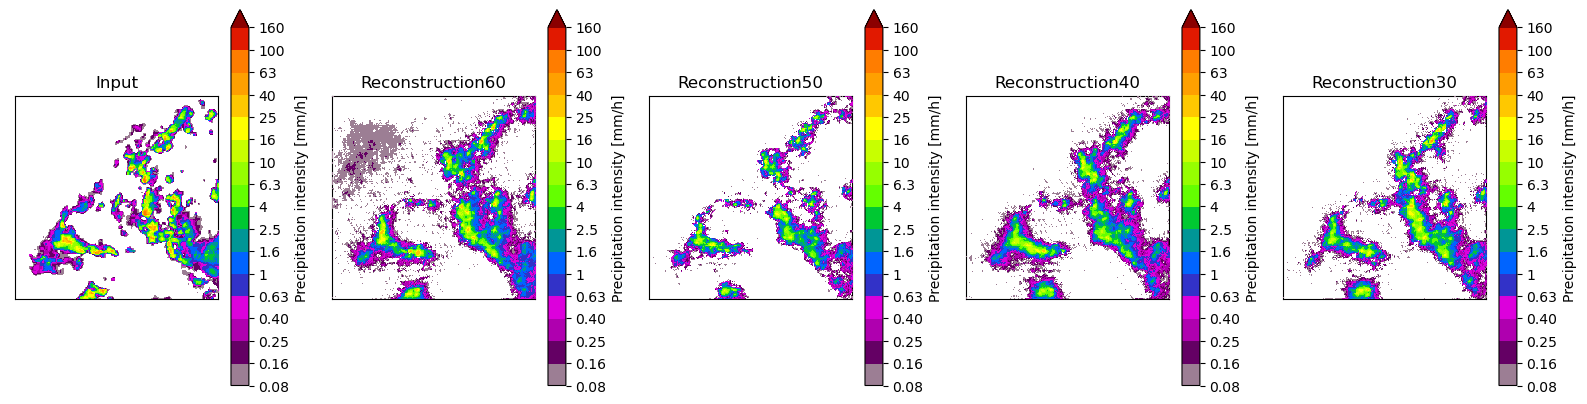

MSE: 18.083 MAE: 0.981 PCC: 0.395 
 MSE: 18.752 MAE: 0.943 PCC: 0.374 
 MSE: 16.837 MAE: 0.887 PCC: 0.48 
 MSE: 17.598 MAE: 0.96 PCC: 0.419 
 CSI(1mm): 0.42 CSI(2mm): 0.332 CSI(8mm): 0.143 
 CSI(1mm): 0.356 CSI(2mm): 0.264 CSI(8mm): 0.078 
 CSI(1mm): 0.409 CSI(2mm): 0.366 CSI(8mm): 0.158 
 CSI(1mm): 0.406 CSI(2mm): 0.336 CSI(8mm): 0.144 
 ACC(1mm): 0.909 ACC(2mm): 0.928 ACC(8mm): 0.965 
 ACC(1mm): 0.905 ACC(2mm): 0.925 ACC(8mm): 0.968 
 ACC(1mm): 0.909 ACC(2mm): 0.933 ACC(8mm): 0.97 
 ACC(1mm): 0.906 ACC(2mm): 0.927 ACC(8mm): 0.966 
 FSS(1km): 0.788 FSS(10km): 0.775 FSS(20km): 0.741 FSS(30km): 0.611 
 FSS(1km): 0.928 FSS(10km): 0.904 FSS(20km): 0.847 FSS(30km): 0.679 
 FSS(1km): 0.939 FSS(10km): 0.913 FSS(20km): 0.86 FSS(30km): 0.705 
 FSS(1km): 0.934 FSS(10km): 0.908 FSS(20km): 0.853 FSS(30km): 0.699 



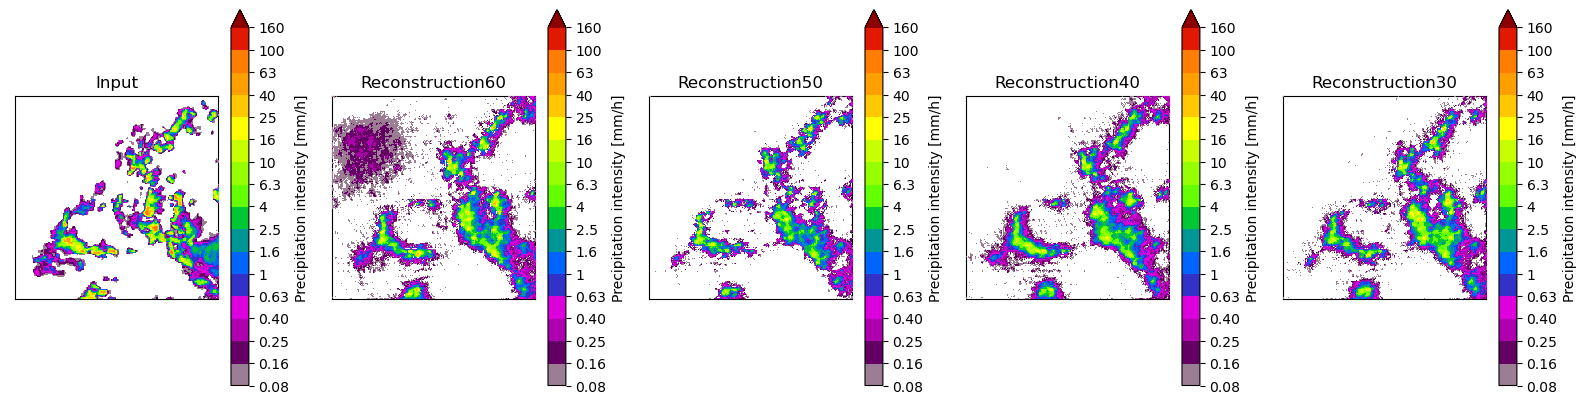

pcc_average: 0.46440000000000003
pcc_average: 0.4728
pcc_average: 0.5064
pcc_average: 0.49420000000000003


In [13]:
#torch.cuda.empty_cache()
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
device = 'cuda:0'
pcc_average = 0
pcc_average1 = 0
pcc_average2 = 0
pcc_average3 = 0

tokenizer=tokenizer.to(device)
for i, images in enumerate(loaders['test']):
    if i<0:continue
    if i>=5:break
        
    image = images[0]
    image = image.unsqueeze(1)
    image = image[4:5, :, :, :]
    input_image= image.to(device)  # batch x
    
    checkpoint = torch.load('/space/junzheyin/check4/vqvae_checkpoint_epoch240', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    a_r = tokenizer.encode_decode(input_image)
    checkpoint = torch.load('/space/junzheyin/check4/vqvae_checkpoint_epoch230', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    a_r1 = tokenizer.encode_decode(input_image)
    checkpoint = torch.load('/space/junzheyin/check4/vqvae_checkpoint_epoch220', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    a_r2 = tokenizer.encode_decode(input_image)
    checkpoint = torch.load('/space/junzheyin/check4/vqvae_checkpoint_epoch200', map_location=device)
    tokenizer.load_state_dict(checkpoint['model_state_dict'])
    a_r3 = tokenizer.encode_decode(input_image)
        #checkpoint = torch.load('/users/zboucher/iris/src/models/tokenizer/vqvae_epoch70', map_location = 'cpu')
        #vae.load_state_dict(checkpoint)
        #a_r2 = vae(a)

    for t in range(1):
        a_display = input_image[t,0,:,:].to('cpu').detach().numpy()*40
        a_r_display = a_r[t,0,:,:].to('cpu').detach().numpy()*40
        a_r1_display = a_r1[t,0,:,:].to('cpu').detach().numpy()*40
        a_r2_display = a_r2[t,0,:,:].to('cpu').detach().numpy()*40
        a_r3_display = a_r3[t,0,:,:].to('cpu').detach().numpy()*40
        
        scores_cat1 = det_cat_fct(a_r_display, a_display, 1)
        scores_cat2 = det_cat_fct(a_r_display, a_display, 2)
        scores_cat8 = det_cat_fct(a_r_display, a_display, 8)
        scores_cont = det_cont_fct(a_r_display, a_display, thr=0.1)
        
        scores_cat11 = det_cat_fct(a_r1_display, a_display, 1)
        scores_cat21 = det_cat_fct(a_r1_display, a_display, 2)
        scores_cat81 = det_cat_fct(a_r1_display, a_display, 8)
        scores_cont1 = det_cont_fct(a_r1_display, a_display, thr=0.1)
        
        scores_cat12 = det_cat_fct(a_r2_display, a_display, 1)
        scores_cat22 = det_cat_fct(a_r2_display, a_display, 2)
        scores_cat82 = det_cat_fct(a_r2_display, a_display, 8)
        scores_cont2 = det_cont_fct(a_r2_display, a_display, thr=0.1)
        
        scores_cat13 = det_cat_fct(a_r3_display, a_display, 1)
        scores_cat23 = det_cat_fct(a_r3_display, a_display, 2)
        scores_cat83 = det_cat_fct(a_r3_display, a_display, 8)
        scores_cont3 = det_cont_fct(a_r3_display, a_display, thr=0.1)
        
        scores_spatial = intensity_scale(a_r_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average += float(np.around(scores_cont['corr_p'],3))
        
        scores_spatial1 = intensity_scale(a_r1_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average1 += float(np.around(scores_cont1['corr_p'],3))
        
        scores_spatial2 = intensity_scale(a_r2_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average2 += float(np.around(scores_cont2['corr_p'],3))
        
        scores_spatial3 = intensity_scale(a_r3_display, a_display, 'FSS', 0.1, [1,10,20,30])
        pcc_average3 += float(np.around(scores_cont3['corr_p'],3))
        if True:
            print('MSE:', np.around(scores_cont['MSE'],3), 
                    'MAE:', np.around(scores_cont['MAE'],3), 
                    'PCC:', np.around(scores_cont['corr_p'],3),'\n',
                    'MSE:', np.around(scores_cont1['MSE'],3), 
                    'MAE:', np.around(scores_cont1['MAE'],3), 
                    'PCC:', np.around(scores_cont1['corr_p'],3),'\n',
                    'MSE:', np.around(scores_cont2['MSE'],3), 
                    'MAE:', np.around(scores_cont2['MAE'],3), 
                    'PCC:', np.around(scores_cont2['corr_p'],3),'\n',
                    'MSE:', np.around(scores_cont3['MSE'],3), 
                    'MAE:', np.around(scores_cont3['MAE'],3), 
                    'PCC:', np.around(scores_cont3['corr_p'],3),'\n', 
                    'CSI(1mm):', np.around(scores_cat1['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat2['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat8['CSI'],3),'\n',
                    'CSI(1mm):', np.around(scores_cat11['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat21['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat81['CSI'],3),'\n',
                    'CSI(1mm):', np.around(scores_cat12['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat22['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat82['CSI'],3),'\n',
                    'CSI(1mm):', np.around(scores_cat13['CSI'],3), # CSI: TP/(TP+FP+FN)
                    'CSI(2mm):', np.around(scores_cat23['CSI'],3),
                    'CSI(8mm):', np.around(scores_cat83['CSI'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat1['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat2['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat8['ACC'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat11['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat21['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat81['ACC'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat12['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat22['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat82['ACC'],3),'\n',
                    'ACC(1mm):', np.around(scores_cat13['ACC'],3), # ACC: (TP+TF)/(TP+TF+FP+FN)
                    'ACC(2mm):', np.around(scores_cat23['ACC'],3),
                    'ACC(8mm):', np.around(scores_cat83['ACC'],3),'\n',
                    'FSS(1km):', np.around(scores_spatial[0][0],3),
                    'FSS(10km):', np.around(scores_spatial[1][0],3),
                    'FSS(20km):', np.around(scores_spatial[2][0],3),
                    'FSS(30km):', np.around(scores_spatial[3][0],3),'\n',
                    'FSS(1km):', np.around(scores_spatial1[0][0],3),
                    'FSS(10km):', np.around(scores_spatial1[1][0],3),
                    'FSS(20km):', np.around(scores_spatial1[2][0],3),
                    'FSS(30km):', np.around(scores_spatial1[3][0],3),'\n',
                    'FSS(1km):', np.around(scores_spatial2[0][0],3),
                    'FSS(10km):', np.around(scores_spatial2[1][0],3),
                    'FSS(20km):', np.around(scores_spatial2[2][0],3),
                    'FSS(30km):', np.around(scores_spatial2[3][0],3),'\n',
                     'FSS(1km):', np.around(scores_spatial3[0][0],3),
                    'FSS(10km):', np.around(scores_spatial3[1][0],3),
                    'FSS(20km):', np.around(scores_spatial3[2][0],3),
                    'FSS(30km):', np.around(scores_spatial3[3][0],3),'\n',
                    )  
            plt.figure(figsize=(16, 5))
            plt.subplot(151)
            plot_precip_field(a_display, title="Input")
            plt.subplot(152)
            plot_precip_field(a_r_display, title="Reconstruction60")
            plt.subplot(153)
            plot_precip_field(a_r1_display, title="Reconstruction50")
            plt.subplot(154)
            plot_precip_field(a_r2_display, title="Reconstruction40")
            plt.subplot(155)
            plot_precip_field(a_r3_display, title="Reconstruction30")
            plt.tight_layout()
            plt.show()
print('pcc_average:', pcc_average/i)
print('pcc_average:', pcc_average1/i)
print('pcc_average:', pcc_average2/i)
print('pcc_average:', pcc_average3/i)

In [ ]:
print(input_image.shape)
print(images.shape)

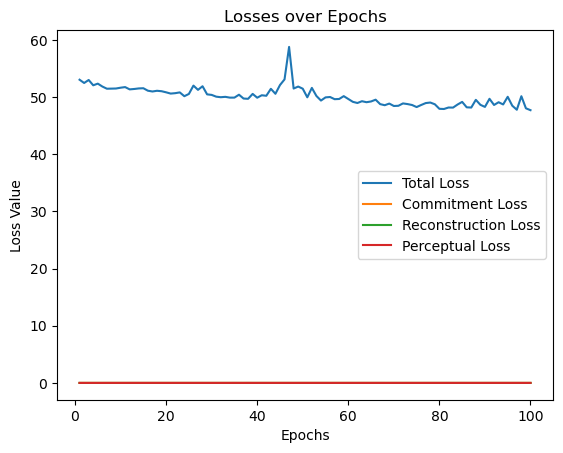

In [15]:
import numpy as np

# Load the NumPy array from file
array = np.load('/space/junzheyin/metrics1/.npy', allow_pickle=True)

import matplotlib.pyplot as plt

metrics = array  # List of 79 metrics dictionaries

# Create lists to store the loss values
total_losses = []
commitment_losses = []
reconstruction_losses = []
perceptual_losses = []

# Extract the loss values from each metrics dictionary
for metric in metrics:
    total_losses.append(metric["<class '__main__.Tokenizer'>/train/total_loss"])
    commitment_losses.append(metric["tokenizer/train/commitment_loss"])
    reconstruction_losses.append(metric["tokenizer/train/reconstruction_loss"])
    perceptual_losses.append(metric["tokenizer/train/perceptual_loss"])

# Plot the losses
epochs = range(1, len(metrics) + 1)

plt.plot(epochs, total_losses, label='Total Loss')
plt.plot(epochs, commitment_losses, label='Commitment Loss')
plt.plot(epochs, reconstruction_losses, label='Reconstruction Loss')
plt.plot(epochs, perceptual_losses, label='Perceptual Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Losses over Epochs')
plt.legend()
plt.show()
